In [23]:
import torch
import torch.nn as nn
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import train_model, CombinedLoss
from models.advanced_autoencoders import AutoEncoder
from torch.optim import Adam
from tqdm import tqdm

# Data Loading

Config initialisation

In [13]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [14]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,…,feature_49,feature_51,feature_52,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,34,1,3.889038,1.509601,0.885045,2.831856,-1.201967,11,7,76,-0.271028,0.695742,0.794157,-0.038239,0.045858,0.030772,-0.900359,-0.382682,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.586801,0.250828,0.294883,0.521403,-0.682683,-0.239552,-0.460341,1.955693,1.485422,-0.253407,…,1.380354,1.116463,1.92235,0.375684,-1.258121,-0.705236,0.748627,0.643394,0.627821,1.411739,-1.36224,0.414762,0.683652,0.896076,-1.06081,-0.636584,-0.423285,0.055839,0.424335,-0.108809,1.035421,1.629745,-0.407497,-0.345388,-0.342097,-0.281208,-0.406524,-0.258637,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941
0,35,1,3.889038,1.636899,1.224167,2.786362,-1.050494,11,7,76,-0.310024,0.05155,0.600186,-0.054901,-0.167249,-0.014244,-0.885459,-0.254649,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.189785,0.945696,1.106982,0.392782,-0.657124,-0.220858,-0.466647,0.24926,0.994481,0.17161,…,1.066112,-1.037891,1.715097,0.067716,-0.876391,0.051228,0.806862,0.703435,0.148378,1.411131,-1.36224,0.41464,0.768911,0.571721,-1.158224,-0.932629,-0.209845,-0.144411,0.304465,-0.11591,0.342235,1.448319,-0.333611,-0.407654,-0.205946,-0.170852,-0.350776,-0.286903,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239
0,36,1,3.889038,1.751107,-0.195755,2.280836,-1.308689,11,7,76,-0.292135,-0.202836,0.615877,-0.075484,-0.318359,-0.049205,-0.930674,-0.666436,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.15204,0.121289,0.794614,0.664937,-0.615451,-0.169856,-0.365646,0.076389,1.351177,0.60942,…,1.095427,-1.714377,1.889433,-0.257992,-1.178176,-0.281169,1.45806,0.599523,-0.062305,1.499916,-1.36224,0.401396,0.701324,0.793441,-0.810332,-0.421096,-0.424012,-0.189834,0.255931,-0.067103,-0.06556,1.456399,-0.405195,-0.351057,-0.189416,-0.220496,-0.373879,-0.340003,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819
0,37,1,3.889038,1.869932,-1.48951,1.470981,-1.040105,11,7,76,-0.34881,-0.476177,0.599473,-0.064814,-0.145902,-0.037824,-0.917428,-0.682684,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.723722,0.289863,0.752283,0.108357,-0.439932,-0.221922,-0.311707,0.186232,1.29547,0.394812,…,0.979125,1.078464,0.791492,-0.55243,-1.282962,0.223554,1.172299,0.73975,-0.584127,1.038086,-1.36224,0.627579,0.601162,0.763969,-0.77326,-0.32353,-0.36246,-0.326542,0.226188,-0.114877,-0.216078,1.169394,-0.405249,-0.399258,-0.282878,-0.236362,-0.322532,-0.284416,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722
0,38,1,3.889038,1.653586,-1.510579,1.045217,-1.045805,11,7,76,-0.359463,-0.173339,0.599964,-0.082462,-0.182317,-0.046782,-0.532617,-0.188155,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.52142,0.685667,0.240129,0.750362,-0.025711,-0.1079

Ensure sorted by time_id to create batches not leaked

In [15]:
data = data.sort(by="time_id")

Define features and target

In [16]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]

Split data

In [17]:
n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
y_train = y.slice(0, n_train)

X_val = X.slice(n_train)
y_val = y.slice(n_train)

Data Wraper

In [18]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        if y.ndim == 1:
            y = y.view(-1, 1)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [20]:
train_data_loader = DataLoader(
    train_dataset, batch_size=2048, shuffle=False, num_workers=8
)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

In [27]:
lr = 1e-2
device = torch.device("cuda")
alpha = 1.0
beta = 1.0
n_epochs = 30

n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 4]

# Test 

In [30]:
activations = (nn.LeakyReLU, nn.LeakyReLU, nn.LeakyReLU)
dropout_ps = (0, 0, 0.3)
use_bns = (True, True, True)

model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    activations=activations,
    dropout_ps=dropout_ps,
    use_bns=use_bns,
    )

  3%|▎         | 1/30 [00:10<04:54, 10.14s/it]

Epoch 01 | loss=3890.146 | R2_rec_train=-5.0896 | R2_rec_val=0.3915 | R2_sup_train=-0.0075 | R2_sup_val=0.0002


  7%|▋         | 2/30 [00:20<04:53, 10.47s/it]

Epoch 02 | loss=387.361 | R2_rec_train=0.5417 | R2_rec_val=0.4612 | R2_sup_train=0.0001 | R2_sup_val=0.0015


 10%|█         | 3/30 [00:31<04:43, 10.48s/it]

Epoch 03 | loss=366.094 | R2_rec_train=0.5995 | R2_rec_val=0.5136 | R2_sup_train=0.0004 | R2_sup_val=0.0002


 13%|█▎        | 4/30 [00:41<04:29, 10.37s/it]

Epoch 04 | loss=351.921 | R2_rec_train=0.6391 | R2_rec_val=0.5513 | R2_sup_train=0.0009 | R2_sup_val=-0.0003


 17%|█▋        | 5/30 [00:51<04:15, 10.22s/it]

Epoch 05 | loss=337.775 | R2_rec_train=0.6761 | R2_rec_val=0.6033 | R2_sup_train=0.0014 | R2_sup_val=0.0023


 20%|██        | 6/30 [01:02<04:08, 10.37s/it]

Epoch 06 | loss=330.707 | R2_rec_train=0.6937 | R2_rec_val=0.6171 | R2_sup_train=0.0027 | R2_sup_val=0.0029


 23%|██▎       | 7/30 [01:12<03:58, 10.37s/it]

Epoch 07 | loss=327.403 | R2_rec_train=0.7017 | R2_rec_val=0.6248 | R2_sup_train=0.0035 | R2_sup_val=0.0026


 27%|██▋       | 8/30 [01:22<03:47, 10.34s/it]

Epoch 08 | loss=325.062 | R2_rec_train=0.7093 | R2_rec_val=0.6381 | R2_sup_train=0.0029 | R2_sup_val=0.0004


 30%|███       | 9/30 [01:33<03:39, 10.47s/it]

Epoch 09 | loss=321.857 | R2_rec_train=0.7183 | R2_rec_val=0.6406 | R2_sup_train=0.0039 | R2_sup_val=-0.0000


 33%|███▎      | 10/30 [01:44<03:31, 10.60s/it]

Epoch 10 | loss=320.100 | R2_rec_train=0.7234 | R2_rec_val=0.6595 | R2_sup_train=0.0050 | R2_sup_val=0.0016


 37%|███▋      | 11/30 [01:55<03:21, 10.60s/it]

Epoch 11 | loss=318.794 | R2_rec_train=0.7283 | R2_rec_val=0.6666 | R2_sup_train=0.0043 | R2_sup_val=0.0015


 40%|████      | 12/30 [02:04<03:02, 10.15s/it]

Epoch 12 | loss=317.179 | R2_rec_train=0.7329 | R2_rec_val=0.6538 | R2_sup_train=0.0056 | R2_sup_val=0.0032


 43%|████▎     | 13/30 [02:14<02:55, 10.31s/it]

Epoch 13 | loss=316.440 | R2_rec_train=0.7361 | R2_rec_val=0.6623 | R2_sup_train=0.0058 | R2_sup_val=0.0027


 47%|████▋     | 14/30 [02:25<02:44, 10.30s/it]

Epoch 14 | loss=315.664 | R2_rec_train=0.7391 | R2_rec_val=0.6546 | R2_sup_train=0.0060 | R2_sup_val=0.0029


 50%|█████     | 15/30 [02:35<02:36, 10.45s/it]

Epoch 15 | loss=314.788 | R2_rec_train=0.7416 | R2_rec_val=0.6523 | R2_sup_train=0.0067 | R2_sup_val=0.0011


 53%|█████▎    | 16/30 [02:46<02:26, 10.46s/it]

Epoch 16 | loss=313.940 | R2_rec_train=0.7451 | R2_rec_val=0.6824 | R2_sup_train=0.0066 | R2_sup_val=0.0040


 57%|█████▋    | 17/30 [02:57<02:16, 10.50s/it]

Epoch 17 | loss=313.622 | R2_rec_train=0.7477 | R2_rec_val=0.6954 | R2_sup_train=0.0064 | R2_sup_val=0.0034


 60%|██████    | 18/30 [03:06<02:03, 10.30s/it]

Epoch 18 | loss=312.479 | R2_rec_train=0.7513 | R2_rec_val=0.7041 | R2_sup_train=0.0067 | R2_sup_val=0.0024


 63%|██████▎   | 19/30 [03:15<01:46,  9.70s/it]

Epoch 19 | loss=311.565 | R2_rec_train=0.7540 | R2_rec_val=0.7041 | R2_sup_train=0.0077 | R2_sup_val=0.0024


 67%|██████▋   | 20/30 [03:23<01:33,  9.31s/it]

Epoch 20 | loss=311.262 | R2_rec_train=0.7554 | R2_rec_val=0.7032 | R2_sup_train=0.0076 | R2_sup_val=0.0048


 70%|███████   | 21/30 [03:31<01:21,  9.01s/it]

Epoch 21 | loss=310.535 | R2_rec_train=0.7568 | R2_rec_val=0.6959 | R2_sup_train=0.0086 | R2_sup_val=0.0040


 73%|███████▎  | 22/30 [03:41<01:13,  9.13s/it]

Epoch 22 | loss=310.283 | R2_rec_train=0.7578 | R2_rec_val=0.6762 | R2_sup_train=0.0093 | R2_sup_val=0.0074


 77%|███████▋  | 23/30 [03:51<01:06,  9.46s/it]

Epoch 23 | loss=310.542 | R2_rec_train=0.7565 | R2_rec_val=0.6604 | R2_sup_train=0.0097 | R2_sup_val=0.0033


 80%|████████  | 24/30 [04:02<00:59,  9.84s/it]

Epoch 24 | loss=308.733 | R2_rec_train=0.7602 | R2_rec_val=0.6889 | R2_sup_train=0.0107 | R2_sup_val=0.0014


 83%|████████▎ | 25/30 [04:13<00:50, 10.16s/it]

Epoch 25 | loss=307.904 | R2_rec_train=0.7621 | R2_rec_val=0.7170 | R2_sup_train=0.0106 | R2_sup_val=0.0047


 87%|████████▋ | 26/30 [04:21<00:38,  9.68s/it]

Epoch 26 | loss=307.134 | R2_rec_train=0.7623 | R2_rec_val=0.7147 | R2_sup_train=0.0109 | R2_sup_val=0.0040


 90%|█████████ | 27/30 [04:32<00:30, 10.01s/it]

Epoch 27 | loss=305.931 | R2_rec_train=0.7646 | R2_rec_val=0.7212 | R2_sup_train=0.0113 | R2_sup_val=0.0009


 93%|█████████▎| 28/30 [04:43<00:20, 10.41s/it]

Epoch 28 | loss=305.392 | R2_rec_train=0.7661 | R2_rec_val=0.7083 | R2_sup_train=0.0121 | R2_sup_val=0.0035


 97%|█████████▋| 29/30 [04:54<00:10, 10.45s/it]

Epoch 29 | loss=304.779 | R2_rec_train=0.7676 | R2_rec_val=0.7142 | R2_sup_train=0.0126 | R2_sup_val=0.0036


100%|██████████| 30/30 [05:05<00:00, 10.18s/it]

Epoch 30 | loss=304.256 | R2_rec_train=0.7690 | R2_rec_val=0.7224 | R2_sup_train=0.0132 | R2_sup_val=0.0027


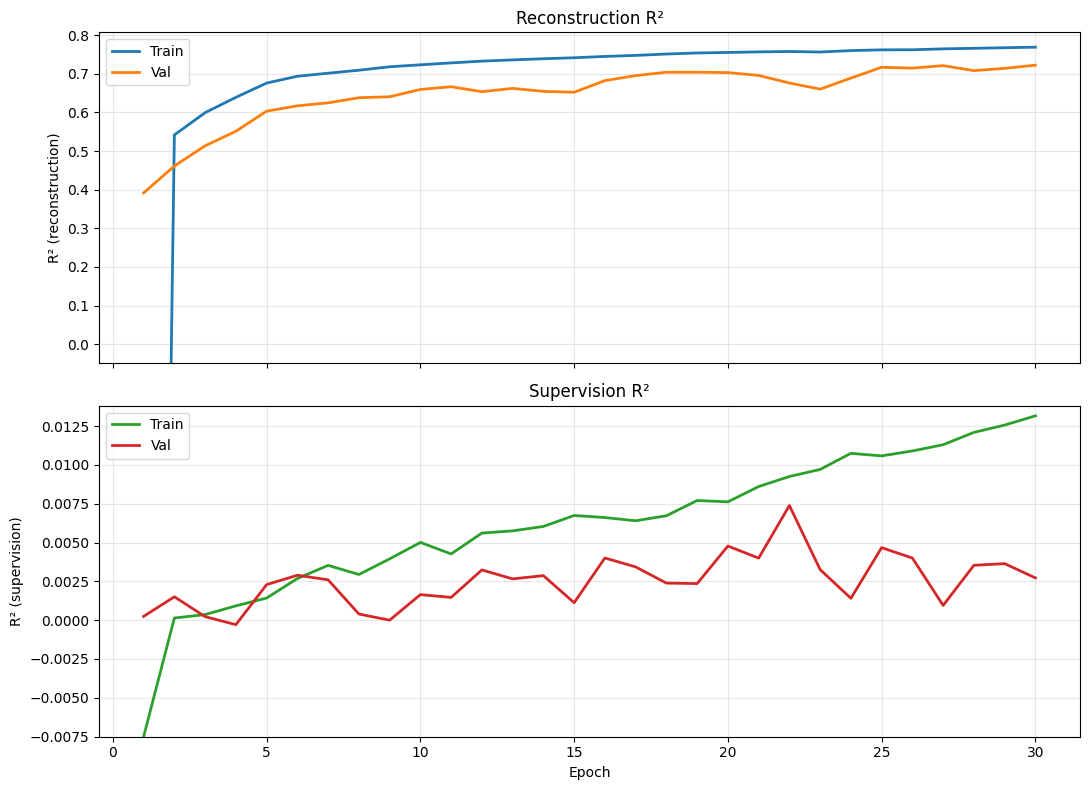

In [31]:
optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
results = train_model(
model=model,
train_loader=train_data_loader,
val_loader=val_data_loader,
criterion=criterion,
optimizer=optimizer,
device=device,
n_epochs=n_epochs,
)